# Setting up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/Emotion-Detection-From-Tweets-Using-BERT-and-SVM-Ensemble-Model-master

/content/drive/MyDrive/Colab Notebooks/Emotion-Detection-From-Tweets-Using-BERT-and-SVM-Ensemble-Model-master


In [ ]:
!gdown --id 1up7d8aWd0H-QDN2konB_4oAwa4oHJQr2
!gdown --id 1doKr_6jKH1kwFFCL92LhAHnDwHVmCQVK
!gdown --id 1mUoiYzyUs6ihlmkqskdPPgo0O1ainWqw
!mkdir ~/.demoji
!mv codes.json ~/.demoji/
!unzip wassa_dataset.zip -y
!rm wassa_dataset.zip
!pip install -qq demoji
!pip install -qq unidecode
!pip install -qq snowballstemmer

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1up7d8aWd0H-QDN2konB_4oAwa4oHJQr2
To: /content/drive/MyDrive/Colab Notebooks/Emotion-Detection-From-Tweets-Using-BERT-and-SVM-Ensemble-Model-master/wassa_dataset.zip
100% 364k/364k [00:00<00:00, 36.2MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1doKr_6jKH1kwFFCL92LhAHnDwHVmCQVK
To: /content/drive/MyDrive/Colab Notebooks/Emotion-Detection-From-Tweets-Using-BERT-and-SVM-Ensemble-Model-master/emoticons.csv
100% 6.02k/6.02k [00:00<00:00, 17.3MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix
from nltk import PorterStemmer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import unidecode
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np
import itertools
from sklearn.naive_bayes import MultinomialNB, GaussianNB
import pickle
import snowballstemmer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [ ]:
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

True

# Loading the dataset

In [ ]:
!ls

Bert.ipynb	      dataset.zip      README.md	wassa_test.csv
Bert_wassa.ipynb      emoticons.csv    SVM.ipynb	wassa_train.csv
best_model_state.bin  LICENSE	       svm_model.obj	wassa_val.csv
checkpoints	      models_anal.png  SVM_wassa.ipynb


In [ ]:
%load_ext autoreload
%autoreload 2
import pandas as pd
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
plt.rc('font', family='serif')

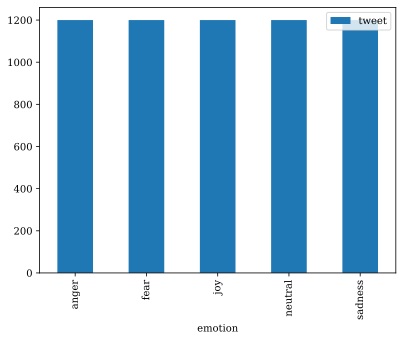

         tweet
emotion       
anger     1200
fear      1200
joy       1200
neutral   1200
sadness   1200


In [ ]:
df_train = pd.read_csv("wassa_train.csv")
df_val = pd.read_csv("wassa_val.csv")
df_test = pd.read_csv("wassa_test.csv")
n_samples = df_train[["tweet", "emotion"]].groupby("emotion").count()
n_samples.plot(kind="bar")
plt.show()

print(n_samples)

In [ ]:
labels = ['joy', 'anger', 'fear', 'sadness', 'neutral']

# Useful functions

In [ ]:
def pickle_object(object, location):
    filehandler = open(location, "wb")
    pickle.dump(object, filehandler)
    filehandler.close()

def pickle_load_object(location):
    file = open(location, 'rb')
    object = pickle.load(file)
    file.close()
    return object

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    cmap='Purples'
    if cmap is None:
        cmap = plt.get_cmap('Purples')

    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(12, 8))
    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    im = plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

def compute_metrics(y_true, predictions):
  average = "macro"
  acc = accuracy_score(y_true, predictions)
  precision = precision_score(y_true, predictions, average=average)
  recall = recall_score(y_true, predictions, average=average)
  f1 = f1_score(y_true, predictions, average=average)
  print(f"Model has acc = {acc}\n, precision = {precision}\n, recall = {recall}\n, f1_score = {f1}\n")




In [ ]:
def preprocess_text(text, stop_words):
    # make lowercase and strip empty spaces
    result = text.lower()
    # strip extra spaces
    result = result.strip()
    # eliminate URLs
    result = re.result = re.sub(r"http\S+", "", result)
    # eliminate email addresses
    result = re.sub('\S*@\S*\s?', '', result)
    # strip diacritics
    result = unidecode.unidecode(result)
    # english stopwords
    word_list = word_tokenize(result)
    # english stemmer
    ps = SnowballStemmer("english")

    stemmed_sentence = ""
    for word in word_list:
        if word not in stop_words:
            stemmed_sentence += ps.stem(word)
            stemmed_sentence += " "

    result = stemmed_sentence
    whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    result = ''.join(filter(whitelist.__contains__, result))
    result = ''.join([i for i in result if not i.isdigit()])
    return result

In [ ]:
def preprocess_text_list(text_list, stop_words):
  for i,text in enumerate(text_list):
    text_list[i] = preprocess_text(text_list[i], stop_words)

In [ ]:
def pickle_object(object, location):
    filehandler = open(location, "wb")
    pickle.dump(object, filehandler)
    filehandler.close()

def pickle_load_object(location):
    file = open(location, 'rb')
    object = pickle.load(file)
    file.close()
    return object

In [ ]:
def compute_metrics(y_true, predictions):
  average = "macro"
  acc = accuracy_score(y_true, predictions)
  precision = precision_score(y_true, predictions, average=average)
  recall = recall_score(y_true, predictions, average=average)
  f1 = f1_score(y_true, predictions, average=average)
  print(f"Model has acc = {acc}\n, precision = {precision}\n, recall = {recall}\n, f1_score = {f1}\n")


# Preprocessing

In [ ]:
train_texts = df_train["tweet"].tolist()
val_texts = df_val["tweet"].tolist()
test_texts = df_test["tweet"].tolist()


train_labels = df_train["emotion"].tolist()
val_labels = df_val["emotion"].tolist()
test_labels = df_test["emotion"].tolist()

train_labels[:10]

['joy',
 'anger',
 'neutral',
 'neutral',
 'anger',
 'joy',
 'neutral',
 'sadness',
 'sadness',
 'neutral']

In [ ]:
len(test_labels), len(train_labels), len(val_labels)

(750, 6000, 750)

## English

In [ ]:
stop_words = stopwords.words("english")  # loads english stopwords

preprocess_text_list(train_texts, stop_words)
preprocess_text_list(val_texts,  stop_words)
preprocess_text_list(test_texts, stop_words)

train_texts[:10]

['kinda wish watch mischiev kiss play kiss ',
 'forget mention bought dreamboy ticket ',
 'yep  jimmi buffett ftw     jimmi need tweet word wisdom everi morn ',
 'blue sky   s still grey hazi window ',
 'move clip youtub tonight vigil held tulsa metropolitan baptist church  terencecruth  justic  sad ',
 'make success  happi forev ',
 'morn hon  breakfast  cant decid ',
 'standard candic start show pout  startasyoumeantogoon  gbbo ',
 '   would frown bit  fold arm  whi everi time m need assist someon expect lil   ',
 'someon make cofffeeeeee  ']

# Encoding

In [ ]:
 # Vectorizing texts
 vectorizer = TfidfVectorizer()
 vectorizer.fit(train_texts)

TfidfVectorizer()

In [ ]:
len(vectorizer.get_feature_names_out())

9239

In [ ]:
vectorized_train_texts = vectorizer.transform(train_texts)
vectorized_val_texts = vectorizer.transform(val_texts)
vectorized_test_texts = vectorizer.transform(test_texts)

In [ ]:
# label encoding
label_encoder = LabelEncoder()
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_val_labels = label_encoder.transform(val_labels)
encoded_test_labels = label_encoder.transform(test_labels)

In [ ]:
encoded_test_labels

array([4, 0, 3, 4, 3, 2, 3, 4, 3, 1, 0, 4, 4, 1, 4, 2, 4, 4, 3, 2, 0, 4,
       3, 1, 3, 3, 3, 0, 0, 4, 4, 2, 2, 2, 0, 0, 3, 1, 3, 3, 4, 3, 4, 4,
       2, 0, 1, 0, 2, 4, 2, 1, 0, 0, 0, 2, 0, 2, 0, 4, 0, 3, 1, 3, 4, 3,
       2, 1, 2, 4, 4, 0, 3, 4, 1, 2, 0, 4, 3, 4, 4, 2, 0, 2, 1, 3, 2, 3,
       0, 3, 0, 3, 1, 1, 2, 0, 3, 3, 1, 2, 3, 1, 3, 1, 0, 0, 3, 2, 4, 3,
       2, 1, 0, 1, 3, 1, 4, 1, 3, 2, 3, 3, 3, 3, 1, 0, 1, 1, 4, 4, 1, 3,
       0, 4, 4, 0, 1, 3, 0, 2, 2, 1, 1, 4, 2, 2, 4, 1, 2, 4, 0, 4, 2, 3,
       2, 3, 0, 3, 1, 2, 4, 1, 3, 2, 1, 2, 1, 0, 4, 3, 0, 3, 2, 3, 2, 4,
       1, 3, 3, 2, 4, 4, 2, 0, 3, 1, 4, 2, 0, 2, 1, 4, 1, 1, 0, 1, 0, 0,
       0, 4, 4, 2, 1, 2, 4, 4, 4, 0, 3, 0, 0, 0, 3, 3, 3, 0, 2, 1, 2, 2,
       1, 1, 4, 4, 0, 1, 4, 1, 2, 1, 2, 2, 3, 0, 3, 0, 3, 0, 3, 4, 2, 1,
       3, 0, 1, 2, 3, 0, 3, 1, 2, 2, 0, 2, 3, 3, 4, 2, 0, 1, 1, 3, 0, 3,
       2, 3, 0, 1, 4, 0, 1, 1, 0, 2, 4, 0, 1, 1, 2, 4, 3, 0, 1, 0, 0, 4,
       1, 2, 1, 0, 1, 2, 1, 0, 0, 0, 2, 3, 0, 4, 0,

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:

clf = KNeighborsClassifier(52, metric='cosine', n_jobs=-1)
clf.fit(vectorized_train_texts, encoded_train_labels)
preds_val = clf.predict(vectorized_val_texts)
compute_metrics(encoded_val_labels, preds_val)

Model has acc = 0.6906666666666667
, precision = 0.7008439544326641
, recall = 0.6906666666666667
, f1_score = 0.6927240861054264



## Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
clf = LogisticRegression()
clf.fit(vectorized_train_texts, encoded_train_labels)
preds_val = clf.predict(vectorized_val_texts)
compute_metrics(encoded_val_labels, preds_val)

Model has acc = 0.832
, precision = 0.8341897710043643
, recall = 0.8320000000000001
, f1_score = 0.8326187643187716



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Multinomial Naive bayes

In [ ]:
mnb = MultinomialNB()
mnb.fit(vectorized_train_texts, encoded_train_labels)

MultinomialNB()

In [ ]:
preds_val = mnb.predict(vectorized_val_texts)

In [ ]:
preds_test = mnb.predict(vectorized_test_texts)

In [ ]:
compute_metrics(encoded_val_labels, preds_val)

Model has acc = 0.792
, precision = 0.7926469935597724
, recall = 0.792
, f1_score = 0.7866189872704864



In [ ]:
compute_metrics(encoded_test_labels, preds_test)

Model has acc = 0.78
, precision = 0.7775252350573119
, recall = 0.78
, f1_score = 0.776566758419676



# Gaussian Naive Bayes

In [ ]:
gaussian_nb = GaussianNB(var_smoothing=5e-1)
gaussian_nb

GaussianNB(var_smoothing=0.5)

In [ ]:
x = vectorized_train_texts.toarray()

In [ ]:
gaussian_nb.fit(x, encoded_train_labels)

GaussianNB(var_smoothing=0.5)

In [ ]:
preds_val = gaussian_nb.predict(vectorized_val_texts.toarray())
preds_test = gaussian_nb.predict(vectorized_test_texts.toarray())

In [ ]:
compute_metrics(encoded_val_labels, preds_val)

Model has acc = 0.7053333333333334
, precision = 0.7526540392247447
, recall = 0.7053333333333335
, f1_score = 0.7116260859726466



In [ ]:
compute_metrics(encoded_test_labels, preds_test)

Model has acc = 0.7026666666666667
, precision = 0.7435331470455272
, recall = 0.7026666666666667
, f1_score = 0.7084013806051445



# SVM

## Defining the model

In [ ]:
kernels = ['linear', 'poly', 'rbf']
for kernel in kernels:
    svm_model = svm.SVC(probability=True, random_state=1, kernel=kernel)
    svm_model.fit(vectorized_train_texts, encoded_train_labels)
    preds = svm_model.predict(vectorized_val_texts)
    compute_metrics(encoded_val_labels, preds)

Model has acc = 0.8493333333333334
, precision = 0.8523656589298916
, recall = 0.8493333333333334
, f1_score = 0.849977485378197

Model has acc = 0.7
, precision = 0.7768891171160331
, recall = 0.7
, f1_score = 0.708274729626148

Model has acc = 0.8706666666666667
, precision = 0.8731144630823447
, recall = 0.8706666666666667
, f1_score = 0.871195184128112



In [ ]:
preds = svm_model.predict(vectorized_test_texts)
compute_metrics(encoded_test_labels, preds)

Model has acc = 0.8386666666666667
, precision = 0.8444967569787878
, recall = 0.8386666666666667
, f1_score = 0.8404916569671421



## Validation

In [ ]:
y_pred = svm_model.predict_log_proba(vectorized_val_texts)
y_pred

array([[-5.90201682e+00, -3.27545278e+00, -2.27643220e-01,
        -4.65368944e+00, -1.87384898e+00],
       [-6.97497972e+00, -2.41584840e-02, -6.70863240e+00,
        -3.91201018e+00, -6.36925809e+00],
       [-1.82302873e+01, -1.28085812e-04, -1.54082094e+01,
        -9.06511156e+00, -1.13114776e+01],
       ...,
       [-6.77446425e-01, -2.50228388e+00, -4.13251502e+00,
        -1.61522998e+00, -1.63320557e+00],
       [-5.14375618e+00, -5.95278746e+00, -9.35343736e-02,
        -2.78266024e+00, -3.96409119e+00],
       [-6.21782626e+00, -4.70996307e+00, -4.98406668e+00,
        -2.04853101e-01, -1.78743988e+00]])

In [ ]:
acc = accuracy_score(encoded_val_labels, np.argmax(y_pred, axis=1))
precision = precision_score(encoded_val_labels, np.argmax(y_pred, axis=1), average="macro")
recall = recall_score(encoded_val_labels, np.argmax(y_pred, axis=1), average="macro")
f1 = f1_score(encoded_val_labels, np.argmax(y_pred, axis=1), average="macro")
print(f"Model has acc = {acc}\n, precision = {precision}\n, recall = {recall}\n, f1_score = {f1}\n")

Model has acc = 0.8706666666666667
, precision = 0.8698489770457325
, recall = 0.8706666666666667
, f1_score = 0.8699267932872615



## Testing

In [ ]:
y_pred = svm_model.predict(vectorized_test_texts)

In [ ]:
compute_metrics(encoded_test_labels, y_pred)


Model has acc = 0.8386666666666667
, precision = 0.8444967569787878
, recall = 0.8386666666666667
, f1_score = 0.8404916569671421



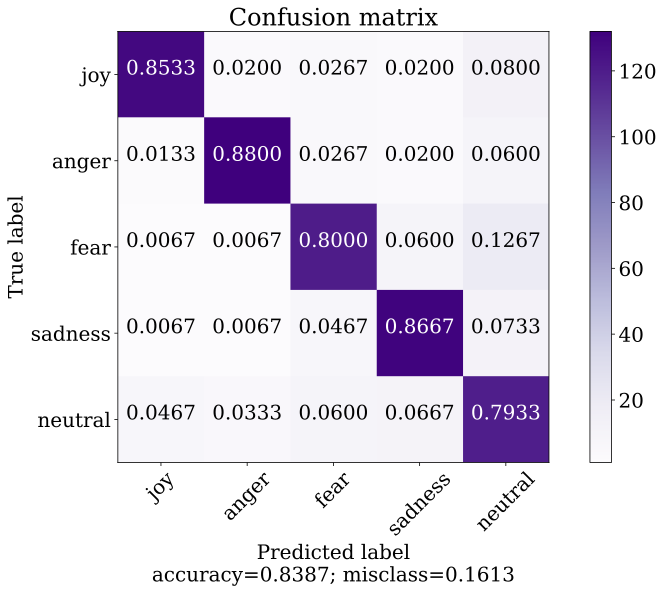

In [ ]:
y_pred = label_encoder.inverse_transform(y_pred)
cm = confusion_matrix(test_labels, y_pred, labels=labels)
plot_confusion_matrix(cm, labels)

In [ ]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

       anger       0.93      0.88      0.90       150
        fear       0.83      0.80      0.82       150
         joy       0.92      0.85      0.89       150
     neutral       0.70      0.79      0.74       150
     sadness       0.84      0.87      0.85       150

    accuracy                           0.84       750
   macro avg       0.84      0.84      0.84       750
weighted avg       0.84      0.84      0.84       750



## Searching for best regelarization coefficient

In [ ]:
np.logspace(-4, 2)

array([1.00000000e-04, 1.32571137e-04, 1.75751062e-04, 2.32995181e-04,
       3.08884360e-04, 4.09491506e-04, 5.42867544e-04, 7.19685673e-04,
       9.54095476e-04, 1.26485522e-03, 1.67683294e-03, 2.22299648e-03,
       2.94705170e-03, 3.90693994e-03, 5.17947468e-03, 6.86648845e-03,
       9.10298178e-03, 1.20679264e-02, 1.59985872e-02, 2.12095089e-02,
       2.81176870e-02, 3.72759372e-02, 4.94171336e-02, 6.55128557e-02,
       8.68511374e-02, 1.15139540e-01, 1.52641797e-01, 2.02358965e-01,
       2.68269580e-01, 3.55648031e-01, 4.71486636e-01, 6.25055193e-01,
       8.28642773e-01, 1.09854114e+00, 1.45634848e+00, 1.93069773e+00,
       2.55954792e+00, 3.39322177e+00, 4.49843267e+00, 5.96362332e+00,
       7.90604321e+00, 1.04811313e+01, 1.38949549e+01, 1.84206997e+01,
       2.44205309e+01, 3.23745754e+01, 4.29193426e+01, 5.68986603e+01,
       7.54312006e+01, 1.00000000e+02])

In [ ]:
C_list = list(np.logspace(-4, 1, 12))
C_list.append(1.000000)
C_list = np.sort(C_list)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
accs_val = []
accs_train = []
for C in tqdm(C_list):
    svm_model = svm.SVC(probability=True, random_state=1, C=C)
    svm_model.fit(vectorized_train_texts, encoded_train_labels)
    preds = svm_model.predict(vectorized_val_texts)
    accs_val.append(np.mean(encoded_val_labels == preds))
    preds = svm_model.predict(vectorized_train_texts)
    accs_train.append(np.mean(encoded_train_labels == preds))

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
plt.rcParams.update({'font.size': 16})

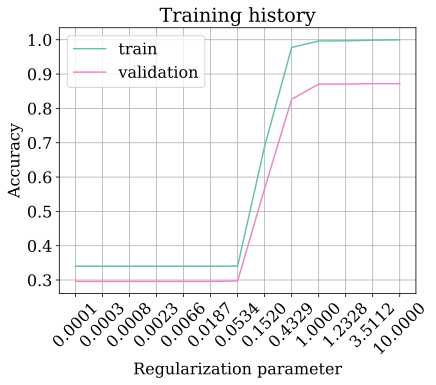

In [ ]:
palette = sns.color_palette('Set2')
plt.figsize=(10, 5)
plt.plot(accs_train, label='train', c=palette[0])
plt.plot(accs_val, label='validation', c=palette[3])
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Regularization parameter')
plt.xticks(np.arange(len(C_list)), [f'{C:.4f}' for C in C_list], rotation=45)
plt.legend()
plt.grid()

In [ ]:
accs_val[-4:]


array([ 1.        ,  1.23284674,  3.51119173, 10.        ])

## Building SVM class

In [ ]:
class SVM_model:
  def __init__(self, classifier, encoder, stop_words, vectorizer):
    self._classifier = classifier
    self._encoder = encoder
    self._stop_words = stop_words
    self._vectorizer = vectorizer

  def _preprocess_text(self, text, stop_words):
    # make lowercase and strip empty spaces
    result = text.lower()
    # strip extra spaces
    result = result.strip()
    # eliminate URLs
    result = re.result = re.sub(r"http\S+", "", result)
    # eliminate email addresses
    result = re.sub('\S*@\S*\s?', '', result)
    # strip diacritics
    result = unidecode.unidecode(result)
    # english stopwords
    word_list = word_tokenize(result)
    # english stemmer
    ps = SnowballStemmer("english")
    stemmed_sentence = ""
    for word in word_list:
        if word not in stop_words:
            stemmed_sentence += ps.stem(word)
            stemmed_sentence += " "
    result = stemmed_sentence
    whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    result = ''.join(filter(whitelist.__contains__, result))
    result = ''.join([i for i in result if not i.isdigit()])
    return result

  def _vectorize_texts(self, texts):
    vectorized_texts = []
    for text in texts:
      processed_text = self._preprocess_text(text, self._stop_words)
      vectorized_texts.append(processed_text)
    return self._vectorizer.transform(vectorized_texts)

  def detect_emotions_with_labels(self, texts):
    vectorized_texts = self._vectorize_texts(texts)
    predictions = self._classifier.predict_log_proba(vectorized_texts)
    predictions  = list(self._encoder.inverse_transform(np.argmax(predictions, axis=1)))
    return predictions

  def detect_emotions_with_proba(self, texts):
    vectorized_texts = self._vectorize_texts(texts)
    predictions = self._classifier.predict_log_proba(vectorized_texts)
    return predictions

  def proba_to_labels(self, proba):
      labels  = list(self._encoder.inverse_transform(np.argmax(proba, axis=1)))
      return labels

In [ ]:
svm_model = svm.SVC(probability=True, random_state=1, C=C_list[-2])
svm_model.fit(vectorized_train_texts, encoded_train_labels)

SVC(C=3.5111917342151275, probability=True, random_state=1)

In [ ]:
svm_cls = SVM_model(svm_model, label_encoder, stop_words, vectorizer)

In [ ]:
predictions = svm_cls.detect_emotions_with_labels(val_texts)
acc = accuracy_score(val_labels, predictions)
acc

0.872

## Testing


In [ ]:
preds_test = svm_model.predict(vectorized_test_texts)
compute_metrics(encoded_test_labels, preds_test)

NameError: ignored

In [ ]:
y_pred = label_encoder.inverse_transform(preds_test)
cm = confusion_matrix(test_labels, y_pred, labels=labels)
plot_confusion_matrix(cm, labels)

NameError: ignored

## Saving the model

In [ ]:
!ls

Bert.ipynb	  emoticons.csv  SVM.ipynb	  wassa_test.csv
Bert_wassa.ipynb  LICENSE	 svm_model.obj	  wassa_train.csv
dataset.zip	  README.md	 SVM_wassa.ipynb  wassa_val.csv


In [ ]:
pickle_object(svm_model, "svm_model.obj")

In [ ]:
svm_model = pickle_load_object("svm_model.obj")

In [ ]:
y_pred = label_encoder.inverse_transform(preds_test)
cm = confusion_matrix(test_labels, y_pred, labels=labels)
plot_confusion_matrix(cm, labels)

NameError: ignored

# Multinomial Naive bayes

In [ ]:
mnb = MultinomialNB(alpha=1)
mnb.fit(vectorized_train_texts, encoded_train_labels)

MultinomialNB(alpha=1)

In [ ]:
preds_val = mnb.predict(vectorized_val_texts)

In [ ]:
preds_test = mnb.predict(vectorized_test_texts)

In [ ]:
compute_metrics(encoded_val_labels, preds_val)

Model has acc = 0.7826666666666666
, precision = 0.7833875616383951
, recall = 0.7826666666666666
, f1_score = 0.7774387339598252



In [ ]:
compute_metrics(encoded_test_labels, preds_test)

Model has acc = 0.78
, precision = 0.7785008337244983
, recall = 0.78
, f1_score = 0.7769269528896695



# Gaussian Naive Bayes

In [ ]:
gaussian_nb = GaussianNB(var_smoothing=5e-1)
gaussian_nb

GaussianNB(var_smoothing=0.5)

In [ ]:
x = vectorized_train_texts.toarray()

In [ ]:
gaussian_nb.fit(x, encoded_train_labels)

GaussianNB(var_smoothing=0.5)

In [ ]:
preds_val = gaussian_nb.predict(vectorized_val_texts.toarray())
preds_test = gaussian_nb.predict(vectorized_test_texts.toarray())

In [ ]:
compute_metrics(encoded_val_labels, preds_val)

Model has acc = 0.7053333333333334
, precision = 0.7477872710093605
, recall = 0.7053333333333335
, f1_score = 0.7107362322002709



In [ ]:
compute_metrics(encoded_test_labels, preds_test)

Model has acc = 0.7026666666666667
, precision = 0.7448890961141931
, recall = 0.7026666666666667
, f1_score = 0.7090340679709878

